In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from statsmodels.distributions.empirical_distribution import ECDF
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from utils import readgtf

base_dir = "/cbscratch/franco/datasets"

import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end', 'typ']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

def read_TFannot(infile):
    TF_list = list()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.rstrip().split()
            TF_list.append(GeneInfo(ensembl_id=arr[0], chrom=int(arr[1]), start=int(arr[2]), end=int(arr[3]), name=arr[4], typ="TF"))
    return TF_list

TF_annot = read_TFannot("../TF_annotation.txt")

import collections
TF_dict = collections.defaultdict(dict)
for g in TF_annot:
    TF_dict[g.chrom][g.ensembl_id] = g.start
    
# def search_TF(TF_dict, chrom, pos):
#     TSS_distance = 1e10
#     cisTF = None
#     found = False
#     for TF in TF_dict[chrom].keys():
#         dist = pos - TF_dict[chrom][TF]
#         if np.abs(dist) < TSS_distance:
#             TSS_distance = dist
#             cisTF = TF
#             found = True
#     if not found:
#         print(chrom, pos)
#     return TSS_distance, cisTF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import mpmath
from operator import attrgetter

mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'fdr', 'target']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

CISTF_FIELDS = ['rsid', 'chrom', 'logp', 'TFpos', 'TFname', 'fdr']
class CisTF(collections.namedtuple('_CisTF', CISTF_FIELDS)):
    __slots__ = ()
    
CT_FIELDS = ['tissue', 'cistot', 'transtot', 'cistrans', 'cistransTF', 'totTF', 'randtrans', 'randTF', 'enrichment', 'cisTFenrichment', 'pval', 'pvalTF']
class CisTrans(collections.namedtuple('_CisTrans', CT_FIELDS)):
    __slots__ = ()
    
def tejaas_saikat(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[3])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, fdr=None, target=None))
    return res
        
def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            chrom = int(arr[6])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, fdr=None, target=None))
    return res

def matrixeqtl(filepath, chrom, fdrcutoff):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr  = line.strip().split("\t")
            rsid = arr[0]
            pos = int(rsid.split("_")[1])
            gene = arr[1].split(".")[0]
            logp = np.log10(float(arr[4]))
            fdr  = np.log10(float(arr[5]))
            if fdr > fdrcutoff:
                break
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, fdr=-fdr, target=gene))
    return res

def matrixeqtl_signif(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr  = line.strip().split("\t")
            chrom = arr[0]
            rsid = arr[1]
            pos = arr[2]
            gene = arr[5]
            logp = float(arr[3])
            fdr  = float(arr[4])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=logp, fdr=fdr, target=gene))
    return res

In [5]:
import os 
from utils import utils
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissues, descriptions = utils.read_tissues(tissue_file)

dataset = "gtex_v8"
expressions = ["tmm_cclm"]
methods = ["matrixeqtl"]
chroms = [str(x) for x in np.arange(1,23)]
fdrcutoff = np.log10(0.05)
basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_new"

In [6]:
def write_eqtls(snp_res, outfile):
    with open(outfile, 'w') as outstream:
        for g in snp_res:
            line = "{:s}\t{:s}\t{:d}\t{:g}\t{:g}\t{:s}\n".format(g.chrom, g.rsid, g.pos, g.logp, g.fdr, g.target)
            outstream.write(line)

for tissue in tissues:
    gtex_t = "-".join([dataset, tissue])
    print("Processing: {:s}".format(tissue), end=" ")
    for expression in expressions:
        for method in methods:
            tissue_path = os.path.join(basepath, expression, gtex_t)
            if os.path.exists(tissue_path):
                snp_res = list()
                trans_snp_res = list()
                for chrom in chroms:
                    print("")
                    cisfile = os.path.join(basepath, expression, gtex_t, method, "chr"+chrom, "cis_eqtl.txt.pos")
                    snp_res += matrixeqtl(cisfile, chrom, fdrcutoff)
                    
                    transfile = os.path.join(basepath, expression, gtex_t, method, "chr"+chrom, "trans_eqtl.txt.pos")
                    trans_snp_res += matrixeqtl(transfile, chrom, fdrcutoff)
                signif_cisfile = os.path.join(basepath, expression, gtex_t, method, "cis_eqtl_signif_fdr0.05.txt")
                signif_transfile = os.path.join(basepath, expression, gtex_t, method, "trans_eqtl_signif_fdr0.05.txt")
                write_eqtls(snp_res, signif_cisfile)
                write_eqtls(trans_snp_res, signif_transfile)
            else:
                print(tissue_path, "does not exist")

Processing: as
Processing: av
Processing: ag
Processing: aa
Processing: ac
Processing: at
Processing: bam
Processing: ban
Processing: bca
Processing: bceh
Processing: bce
Processing: bco
Processing: bfr
Processing: bhi
Processing: bhy
Processing: bnu
Processing: bpu
Processing: bsp
Processing: bsu
Processing: br
Processing: ebv
Processing: fib
Processing: cols
Processing: colt
Processing: esog
Processing: esom
Processing: esomu
Processing: haa
Processing: hlv
Processing: kc
Processing: liv
Processing: lu
Processing: msg
Processing: ms
Processing: nt
Processing: pan
Processing: pit
Processing: snse
Processing: sse
Processing: si
Processing: spl
Processing: sto
Processing: thy
Processing: wb
Processing: ov
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_new/tmm_cclm/gtex_v8-ov does not exist
Processing: pro
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_new/tmm_cclm/gtex_v8-pro does not exist
Processing: tes
/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_new/tmm_cclm/gtex_v8-tes 

In [39]:
def cross_ref_cis_trans(trans_ids, cis_eqtls, TF_dict, verbose=True):
    cis_ids = list(set([x.rsid for x in cis_eqtls]))
    
    #Intersection between cis-eqtls (MatrixEQTL) and trans-eqtls (TEJAAS)
    cis_trans_eqtls = list(set.intersection(set(trans_ids), set(cis_ids)))
    
    #set up a dict for fast look up later
    cis_trans_dict = dict()
    for x in cis_trans_eqtls:
        cis_trans_dict[x] = True
    
    # List of target genes of the cis-trans-eqtls
    cis_target_eqtls = [x for x in cis_eqtls if cis_trans_dict.get(x.rsid, False)]
    
    # How many of those cis-trans-SNPs targets are TFs in MatrixEQTL?
    # beware, one snp may target multiple TF! reduce counts
    cis_TF_eqtls = [x for x in cis_target_eqtls if TF_dict[int(x.chrom)].get(x.target, False)]
    cis_tfs_ids_list = list(set([x.rsid for x in cis_TF_eqtls]))
    
    # Unique TFs targeted?
    target_TFs = list(set([x.target for x in cis_TF_eqtls]))

    if verbose:
        print("|{: >7}|{: >9}|{: >9}|{: >10}|{: >10}".format(len(cis_ids), len(trans_ids), len(cis_trans_eqtls), len(cis_tfs_ids_list), len(target_TFs)), end="")
    return cis_trans_eqtls, cis_TF_eqtls

def crossref_trans_tejaas(transeqtls, cis_eqtls, TF_dict, verbose=True):
    trans_ids = [x.rsid for x in transeqtls]
    a, b = cross_ref_cis_trans(trans_ids, cis_eqtls, TF_dict, verbose=verbose)
    return a, b

import random

def sample_background_50000(ciseqtls, TF_dict):
    randtrans = list()
    randTF    = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    for nid in ["{:03d}".format(x) for x in np.arange(1, 11)]:
        Nrand="50000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_sampling_ids/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [line.rstrip() for line in ins]

        a, b = cross_ref_cis_trans(rand_ids, ciseqtls, TF_dict, verbose=False)
        randtrans.append( len(a) )
        randTF.append( len(b) )
    return np.mean(randtrans), np.mean(randTF)

def sample_1000_pval(ciseqtls, ntrans, TF_dict):
    randtrans = list()
    randTF    = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    start = time.time()
    for nid in ["{:05d}".format(x) for x in np.arange(1, 1001)]:
        Nrand="10000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_sampling_ids/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [line.rstrip() for line in ins]
        
        sampled_rand_ids = random.sample(rand_ids, ntrans)
        a, b = cross_ref_cis_trans(sampled_rand_ids, ciseqtls, TF_dict, verbose=False)
        randtrans.append( len(a) )
        randTF.append( len(b) )
    end = time.time()
    #print("Sampling took {:g} seconds".format( end-start))
    return randtrans, randTF

In [46]:
###################################
########### MAF 0.01 ##############
###################################

meqtl_expr  = "tmm_cclm"
tejaas_expr = "raw"
NTOT_SNPS   = 4522283

print("{: >6}|{: >7}|{: >9}|{: >9}|{: >10}|{: >10}|{: >10}|{: >10}|{: >5}|{: >5}".format("Tissue", "Tot cis", 
                                                                                       "Tot trans", "cis-trans", 
                                                                                       "cistransTF", "Target TFs", 
                                                                                       "Enrichment", "cisTFenrichment",
                                                                                       "pval", "pvalTF"))

basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8"

res_dict = dict()
for tissue in tissues:
    gtex_t = "-".join([dataset, tissue])
    print("{: >6}".format(tissue), end="")
    
    tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls.txt")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    transeqtls = tejaas_saikat(tejaas_file)
    
#     tejaas_file = os.path.join(basepath, "raw", "gtex_v8-"+tissue, "tejaas", "permnull_sb0.1_knn30", "trans_eqtls_5e-08.txt")
#     if not os.path.exists(tejaas_file):
#         print("{:s} has no trans-eqtl results".format(tissue))
#         continue
#     transeqtls = tejaas(tejaas_file)
    
    if len(transeqtls) < 200:
        print("{:s} has less than 200 trans-eqtls".format(tissue))
        continue
    
    signif_cisfile = os.path.join(basepath, meqtl_expr, gtex_t, "matrixeqtl", "cis_eqtl_signif_fdr0.05.txt")
    if not os.path.exists(signif_cisfile):
        print("{:s} has no cis-file (probably no covariates)".format(tissue))
        continue
    ciseqtls = matrixeqtl_signif(signif_cisfile)
    cis_ids = list(set([x.rsid for x in cis_eqtls]))
    
    if len(ciseqtls) < 200:
        print("{:s} has less than 200 cis-eqtls".format(tissue))
        continue
    
    cis_trans_eqtls, cis_TF_eqtls = crossref_trans_tejaas(transeqtls, ciseqtls, TF_dict)
    target_TFs = list(set([x.target for x in cis_TF_eqtls]))
    cis_TF_eqtls_rsids = list(set([x.rsid for x in cis_TF_eqtls]))
        
    FRAC_GWCIS_TS = len(ciseqtls)/NTOT_SNPS
    randtrans, randTF = sample_background_50000(ciseqtls, TF_dict) 
    
    num = len(cis_trans_eqtls) / len(transeqtls)
    den = randtrans / 50000 
    
    numTF = len(cis_TF_eqtls_rsids) / len(cis_trans_eqtls)
    denTF = randTF / randtrans
    
    actual_enrichment = num/den
    actual_cisTFenrichment = numTF / denTF
    
#     ### Calculate p-value
#     ntrans = len(transeqtls)
#     randtrans1k, randTF1k = sample_1000_pval(ciseqtls, ntrans, TF_dict)
#     num_null = np.array(randtrans1k) /  ntrans
#     numTF_null = np.array(randTF1k) / np.array(randtrans1k) 

#     null_enrichments = num_null / den
#     null_TFenrichments = numTF_null / denTF
#     ecdf = ECDF(null_enrichments)
#     pval = 1 - ecdf(actual_enrichment)
    
#     ecdf = ECDF(null_TFenrichments)
#     pvalTF = 1 - ecdf(actual_cisTFenrichment
    
    pvalTF = 1
    pval   = 1
        
    res_dict[tissue] = CisTrans(tissue=tissue, cistot=len(cis_ids), transtot=len(transeqtls), 
                                cistrans=len(cis_trans_eqtls), cistransTF=len(cis_TF_eqtls_rsids), 
                                totTF=len(target_TFs), randtrans=randtrans, randTF=randTF, 
                                enrichment=actual_enrichment, cisTFenrichment = actual_cisTFenrichment, pval=pval, pvalTF=pvalTF)
    
    print("|{: >10}|{: >10}|{: >5}|{: >6}".format(actual_enrichment, actual_cisTFenrichment , pval, pvalTF))
# with open("CisEQTL_enrichment_results.txt", 'w') as outstream:
#     for t in tissues:
#         if t in res_dict:
#             e = res_dict[t]
#             fmt_string = "{:s}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:g}\t{:g}\t{:g}\t{:g}\n"
#             outstream.write(fmt_string.format(e.tissue, e.cistot, e.trantot,
#                                               e.cistrans, e.cistransTF, e.totTF,
#                                               e.randtrans, e.randTF, 
#                                               e.enrichment, e.cisTFenrichment,
#                                               e.pval, e.pvalTF))    

# Tissue|Tot cis|Tot trans|cis-trans|cistransTF|Target TFs|Enrichment|cisTFenrichment| pval|pvalTF
#     as| 955202|     1646|      233|         5|         4|0.6723886149012699|0.1123868182966419|    1|     1
#     av| 858784|      514|      174|        13|         9|1.7863737626949063|0.4031147258783342|    1|     1
#     ag| 585863|      265|       69|        40|         6|2.0130609729911404|3.536888159693738|    1|     1
#     aa| 779986|     3999|     1136|       163|        38|1.6526133720850218|0.8140498048028085|    1|     1
#     ac| 534140|     3384|      764|        99|        19|1.9194069366200976|0.8241512600379237|    1|     1
#     at| 923673|     1068|      228|         8|         2|1.048006647230372|0.18586199219705182|    1|     1
#    bam| 365633|     4918|      413|       104|        11|1.0472804044950916|1.8396607345809308|    1|     1

Tissue|Tot cis|Tot trans|cis-trans|cistransTF|Target TFs|Enrichment|cisTFenrichment| pval|pvalTF
    as

NameError: name 'cis_eqtls' is not defined

In [22]:
###################################
########### MAF 0.05 ##############
###################################

meqtl_expr  = "tmm_cclm"
tejaas_expr = "raw"
NTOT_SNPS   = 4522283

print("{: >6}|{: >7}|{: >9}|{: >9}|{: >10}|{: >10}|{: >10}|{: >10}|{: >5}|{: >5}".format("Tissue", "Tot cis", 
                                                                                       "Tot trans", "cis-trans", 
                                                                                       "cistransTF", "Target TFs", 
                                                                                       "Enrichment", "cisTFenrichment",
                                                                                       "pval", "pvalTF"))

res_dict_maf05 = dict()
for tissue in tissues:
    gtex_t = "-".join([dataset, tissue])
    print("{: >10}|".format(tissue), end="")
    
    tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls_maf0.05.txt")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    transeqtls = tejaas_saikat(tejaas_file)
    
    if len(transeqtls) < 200:
        print("{:s} has less than 200 trans-eqtls".format(tissue))
        continue
    
    signif_cisfile = os.path.join(basepath, meqtl_expr, gtex_t, "matrixeqtl", "cis_eqtl_signif_fdr0.05.txt")
    if not os.path.exists(signif_cisfile):
        print("{:s} has no cis-file (probably no covariates)".format(tissue))
        continue
    ciseqtls = matrixeqtl_signif(signif_cisfile)
    
    if len(ciseqtls) < 200:
        print("{:s} has less than 200 cis-eqtls".format(tissue))
        continue
        
    FRAC_GWCIS_TS = len(ciseqtls)/NTOT_SNPS
    randtrans, randTF = sample_background_50000(ciseqtls, TF_dict)
        
    cis_trans_eqtls, cis_TF_eqtls = crossref_trans_tejaas(transeqtls, ciseqtls, TF_dict)
    target_TFs = list(set([x.target for x in cis_TF_eqtls]))
    
    num = len(cis_trans_eqtls) / len(transeqtls)
    den = randtrans / 50000 
    
    numTF = len(cis_TF_eqtls) / len(cis_trans_eqtls)
    denTF = randTF / randtrans
    
    actual_enrichment = num/den
    actual_cisTFenrichment = numTF / denTF
    
    ### Calculate p-value
    ntrans = len(transeqtls)
    randtrans1k, randTF1k = sample_1000_pval(ciseqtls, ntrans, TF_dict)
    num_null = np.array(randtrans1k) /  ntrans
    numTF_null = np.array(randTF1k) / np.array(randtrans1k) 

    null_enrichments = num_null / den
    null_TFenrichments = numTF_null / denTF
    ecdf = ECDF(null_enrichments)
    pval = 1 - ecdf(actual_enrichment)
    
    ecdf = ECDF(null_TFenrichments)
    pvalTF = 1 - ecdf(actual_cisTFenrichment)
        
    res_dict_maf05[tissue] = CisTrans(tissue=tissue, cistot=len(ciseqtls), transtot=len(transeqtls), 
                                cistrans=len(cis_trans_eqtls), cistransTF=len(cis_TF_eqtls), 
                                totTF=len(target_TFs), randtrans=randtrans, randTF=randTF, 
                                enrichment=actual_enrichment, cisTFenrichment = actual_cisTFenrichment, pval=pval, pvalTF=pvalTF)
    
    print("|{: >10}|{: >10}|{: >10}|{: >10}".format(actual_enrichment, actual_cisTFenrichment , pval, pvalTF))
    
    
with open("CisEQTL_enrichment_results_maf0.05.txt", 'w') as outstream:
    for t in tissues:
        if t in res_dict_maf05:
            e = res_dict_maf05[t]
            fmt_string = "{:s}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:g}\t{:g}\t{:g}\t{:g}\n"
            outstream.write(fmt_string.format(e.tissue, e.cistot, e.trantot,
                                              e.cistrans, e.cistransTF, e.totTF,
                                              e.randtrans, e.randTF, 
                                              e.enrichment, e.cisTFenrichment,
                                              e.pval, e.pvalTF))    

    Tissue|   Tot cis| Tot trans| cis-trans|cistransTF|Target TFs|Enrichment
        as|    490214|       613|       110|         3|         2|1.6621774276486654
        av|    452050|       501|       167|        16|         9|3.3398794971477432
        ag|    325792|       265|        69|       160|         6|3.619468966200979
        aa|    417430|      3916|      1097|       320|        36|3.050824296571136
        ac|    301391|      3366|       763|       116|        19|3.4175393530328364
        at|    475304|       475|        58|         7|         1|1.1673989747016589
       bam|    239078|      3962|       405|       121|        12|1.9557857967764127
       ban|    268990|      2154|        96|        14|         6|0.7535293194019577
       bca|bca has less than 200 trans-eqtls
      bceh|bceh has less than 200 trans-eqtls
       bce|bce has less than 200 trans-eqtls
       bco|bco has less than 200 trans-eqtls
       bfr|bfr has less than 200 trans-eqtls
       bhi|bhi has 

In [22]:
###################################
###### MAF 0.05 + LD pruning ######
###################################

meqtl_expr  = "tmm_cclm"
tejaas_expr = "raw"
NTOT_SNPS   = 4522283

print("{: >6}|{: >7}|{: >9}|{: >9}|{: >10}|{: >10}|{: >10}|{: >10}|{: >5}|{: >5}".format("Tissue", "Tot cis", 
                                                                                       "Tot trans", "cis-trans", 
                                                                                       "cistransTF", "Target TFs", 
                                                                                       "Enrichment", "cisTFenrichment",
                                                                                       "pval", "pvalTF"))

res_dict_maf05_ld = dict()
for tissue in tissues:
    gtex_t = "-".join([dataset, tissue])
    print("{: >6}|".format(tissue), end="")
    
    tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls_maf0.05.txt.ld_prune")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    transeqtls = tejaas_saikat(tejaas_file)
    
    if len(transeqtls) < 100:
        print("{:s} has less than 100 trans-eqtls".format(tissue))
        continue
    
    signif_cisfile = os.path.join(basepath, meqtl_expr, gtex_t, "matrixeqtl", "cis_eqtl_signif_fdr0.05.txt")
    if not os.path.exists(signif_cisfile):
        print("{:s} has no cis-file (probably no covariates)".format(tissue))
        continue
    ciseqtls = matrixeqtl_signif(signif_cisfile)
    
    if len(ciseqtls) < 200:
        print("{:s} has less than 200 cis-eqtls".format(tissue))
        continue
        
    FRAC_GWCIS_TS = len(ciseqtls)/NTOT_SNPS
    randtrans, randTF = sample_background_50000(ciseqtls, TF_dict)
        
    cis_trans_eqtls, cis_TF_eqtls = crossref_trans_tejaas(transeqtls, ciseqtls, TF_dict)
    target_TFs = list(set([x.target for x in cis_TF_eqtls]))
    num = len(cis_trans_eqtls) / len(transeqtls)
    den = randtrans / 50000 
    
    numTF = len(cis_TF_eqtls) / len(cis_trans_eqtls)
    denTF = randTF / randtrans
    
    actual_enrichment = num/den
    actual_cisTFenrichment = numTF / denTF
    
    ### Calculate p-value
    ntrans = len(transeqtls)
    randtrans1k, randTF1k = sample_1000_pval(ciseqtls, ntrans, TF_dict)
    num_null = np.array(randtrans1k) /  ntrans
    numTF_null = np.array(randTF1k) / np.array(randtrans1k) 

    null_enrichments = num_null / den
    null_TFenrichments = numTF_null / denTF
    ecdf = ECDF(null_enrichments)
    pval = 1 - ecdf(actual_enrichment)
    
    ecdf = ECDF(null_TFenrichments)
    pvalTF = 1 - ecdf(actual_cisTFenrichment)
        
    res_dict_maf05_ld[tissue] = CisTrans(tissue=tissue, cistot=len(ciseqtls), transtot=len(transeqtls), 
                                cistrans=len(cis_trans_eqtls), cistransTF=len(cis_TF_eqtls), 
                                totTF=len(target_TFs), randtrans=randtrans, randTF=randTF, 
                                enrichment=actual_enrichment, cisTFenrichment = actual_cisTFenrichment, pval=pval, pvalTF=pvalTF)
    
    print("|{: >10}|{: >10}|{: >10}|{: >10}".format(actual_enrichment, actual_cisTFenrichment , pval, pvalTF))

Tissue|Tot cis|Tot trans|cis-trans|cistransTF|Target TFs|Enrichment|cisTFenrichment| pval|pvalTF
    as|| 490214|      219|       33|         2|         2|1.3957736481488108|0.28514377629691845|0.01200000000000001|     0.904
    av|| 452050|      204|       58|        11|         9|2.8487207475671927|0.9239648944443135|       0.0|     0.469
    ag|ag has less than 100 trans-eqtls
    aa|| 417430|     1293|      291|        58|        33|2.4510248594059294|1.0426898413981276|       0.0|0.46399999999999997
    ac|| 301391|     1101|      192|        30|        19|2.6291599472459057|0.9200772372159091|       0.0|     0.554
    at|| 475304|      146|       23|         1|         1|1.5061211382399178|0.20824490218486322|0.018000000000000016|     0.894
   bam|| 239078|     1312|       98|        19|        10|1.4291340824095875|1.3142936552052729|       0.0|     0.248
   ban|| 268990|      737|       36|         6|         6|0.825866089208862|1.063853514641341|     0.876|     0.397
   bca|bc

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


|2.3875608081893334|1.139598781779661|       0.0|     0.351
   fib|fib has no trans-eqtl results
  cols|cols has less than 100 trans-eqtls
  colt|| 402187|      839|      289|        76|        46|3.8792027537668403|1.3835286901193216|       0.0|0.19399999999999995
  esog|esog has less than 100 trans-eqtls
  esom|esom has less than 100 trans-eqtls
 esomu|esomu has less than 100 trans-eqtls
   haa|haa has less than 100 trans-eqtls
   hlv|| 397985|      143|       47|         7|         5|3.752641220671911|0.8242402080067543|       0.0|     0.472
    kc|kc has no trans-eqtl results
   liv|liv has less than 100 trans-eqtls
    lu|| 480116|      365|      103|        16|        12|2.6670678489113833|0.7819164364959862|       0.0|     0.612
   msg|msg has less than 100 trans-eqtls
    nt|| 492106|      206|       13|         0|         0|0.5816187362122804|       0.0|     0.984|     0.957
   pan|pan has less than 100 trans-eqtls
   pit|pit has less than 100 trans-eqtls
  snse|| 477038|     

In [27]:
 
with open("CisEQTL_enrichment_results_maf0.05_ldpruned.txt", 'w') as outstream:
    for t in tissues:
        if t in res_dict_maf05_ld:
            e = res_dict_maf05_ld[t]
            print(e)
            fmt_string = "{:s}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:g}\t{:g}\t{:g}\t{:g}\t{:g}\t{:g}\n"
            outstream.write(fmt_string.format(e.tissue, e.cistot, e.transtot,
                                              e.cistrans, e.cistransTF, e.totTF,
                                              e.randtrans, e.randTF, 
                                              e.enrichment, e.cisTFenrichment,
                                              e.pval, e.pvalTF))    

CisTrans(tissue='as', cistot=1094762, transtot=219, cistrans=33, cistransTF=2, totTF=2, randtrans=5397.9, randTF=1147.3, enrichment=1.3957736481488108, cisTFenrichment=0.28514377629691845, pval=0.01200000000000001, pvalTF=0.904)
CisTrans(tissue='av', cistot=973773, transtot=204, cistrans=58, cistransTF=11, totTF=9, randtrans=4990.2, randTF=1024.3, enrichment=2.8487207475671927, cisTFenrichment=0.9239648944443135, pval=0.0, pvalTF=0.469)
CisTrans(tissue='aa', cistot=859528, transtot=1293, cistrans=291, cistransTF=58, totTF=33, randtrans=4591.1, randTF=877.6, enrichment=2.4510248594059294, cisTFenrichment=1.0426898413981276, pval=0.0, pvalTF=0.46399999999999997)
CisTrans(tissue='ac', cistot=557686, transtot=1101, cistrans=192, cistransTF=30, totTF=19, randtrans=3316.4, randTF=563.2, enrichment=2.6291599472459057, cisTFenrichment=0.9200772372159091, pval=0.0, pvalTF=0.554)
CisTrans(tissue='at', cistot=1031502, transtot=146, cistrans=23, cistransTF=1, totTF=1, randtrans=5229.8, randTF=1091

In [9]:
import json
import os 
from utils import utils

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

json_file = "../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissues, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

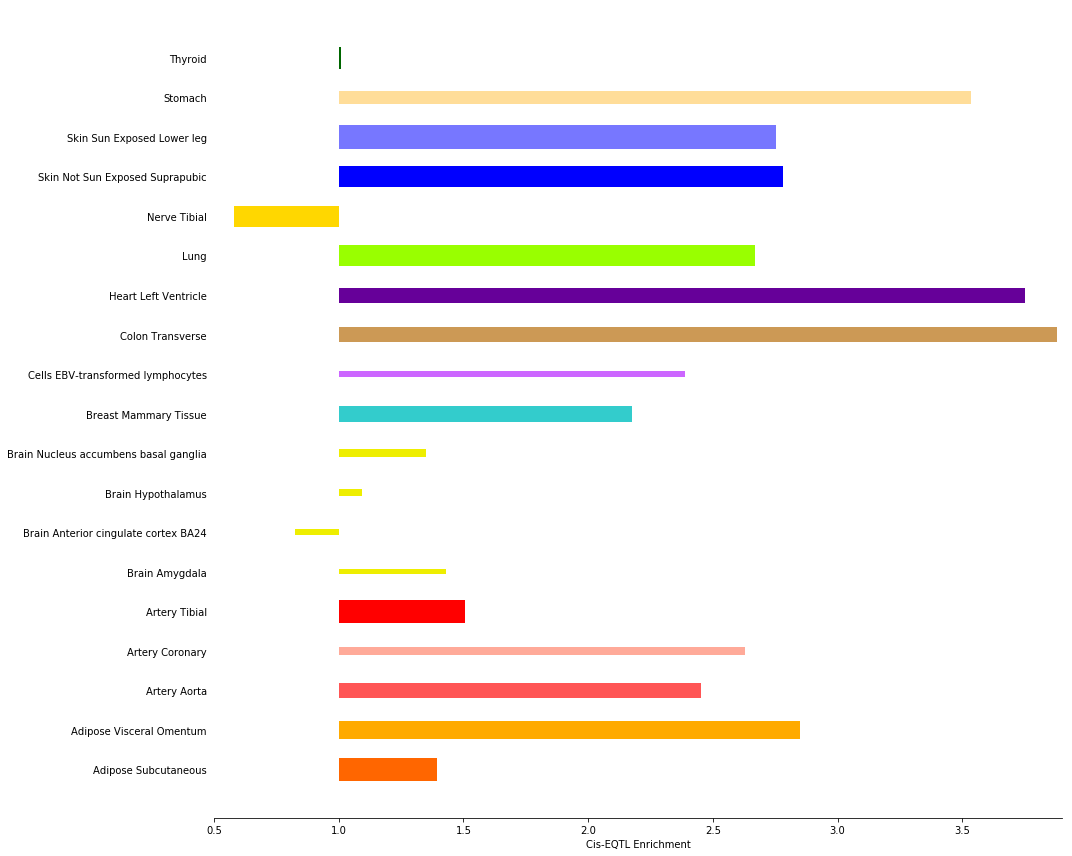

In [10]:

objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_width = list()

for tshort in tissues:
    if tshort in res_dict_maf05:
        nteqtl = res_dict_maf05[tshort].transtot
        if nteqtl > 0:
            objects.append(tissue_names[tshort])
            performance.append(res_dict_maf05[tshort].enrichment - 1.0)
            significance.append('')
#             if tshort in tissue_pval_dict:
#             if tissue_pval_dict[tshort] <= 0.001:
#                 significance.append('***')
#             elif tissue_pval_dict[tshort] <= 0.01:
#                 significance.append('**')
#             elif tissue_pval_dict[tshort] <= 0.05:
#                 significance.append('*')
#             else:
#                 significance.append('')
            bar_colors.append(tissue_colors[tshort])
            bar_width.append(tissue_samples[tshort])

bar_width = np.array(bar_width)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.001 * bar_width)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('Cis-EQTL Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "cis_eqtl_enrichment_maf0.05_ld_pruned.png"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [224]:
bar_width

array([[581, 469, 233, 387, 213, 584, 129, 147, 175, 165, 170, 202, 126,
        396, 147, 368, 386, 515, 706, 532, 517, 605, 174, 324, 574]])